In [1]:
import numpy as np
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

Loading in Data...

In [16]:
from utils import fetch_and_cache_gdrive
from sklearn.model_selection import train_test_split


original_training_data = pd.read_csv('train.csv')

Y_train = np.array(original_training_data['spam'])
#Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
original_training_data['subject'] = original_training_data['subject'].str.lower()


original_training_data

,id,subject,email,spam
0,0,subject: a&l daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"subject: wired: ""stronger ties between isps an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,subject: it's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,subject: re: [ilug] newbie seeks advice - suse...,hehe sorry but if you hit caps lock twice the ...,0
...,...,...,...,...
8343,8343,subject: re: alsa (almost) made easy\n,"thanks for this, i'm going to give them anothe...",0
8344,8344,subject: re: goodbye global warming\n,thanks for the link - i'm fascinated by archae...,0
8345,8345,subject: hello\n,we need help. we are a 14 year old fortune 50...,1
8346,8346,subject: your application is below. expires ju...,<html>\n \n \n <head> \n <meta charset=3dutf-8...,1


Replace na values..

In [3]:
original_training_data = original_training_data.fillna('')

This is a function that will allow me to create a feature for each word in a list of words where there will be a 1 in a word's column at row i if the ith email in the training data has that word in the email/subject.

In [38]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    for x in texts:
        if type(x) == str:
            lst = [1 if y in x else 0 for y in words]
        else:
            lst = [0 for y in words]
        indicator_array.append(lst)
    return indicator_array

Here I used a counter to find the most common words that appeared in the emails and subject lines. 

In [186]:
import collections
lst_email = []
lst_subject = []
display(original_training_data)
counter_sub = collections.Counter()
counter_email = collections.Counter()

for x in range(len(original_training_data)):
    counter_sub = collections.Counter(original_training_data.iloc[x, 1].split(' ')) + counter_sub
    counter_email = collections.Counter(original_training_data.iloc[x, 2].split(' ')) + counter_email
display(counter_sub.most_common(300), counter_email.most_common(300))

,id,subject,email,spam
7657,7657,Subject: Patch to enable/disable log\n,"While I was playing with the past issues, it a...",0
6911,6911,Subject: When an engineer flaps his wings\n,URL: http://diveintomark.org/archives/2002/10/...,0
6074,6074,Subject: Re: [Razor-users] razor plugins for m...,"No, please post a link!\n \n Fox\n ----- Origi...",0
4376,4376,Subject: NYTimes.com Article: Stop Those Press...,This article from NYTimes.com \n has been sent...,0
5766,5766,Subject: What's facing FBI's new CIO? (Tech Up...,<html>\n <head>\n <title>Tech Update Today</ti...,0
...,...,...,...,...
5734,5734,Subject: [Spambayes] understanding high false ...,">>>>> ""TP"" == Tim Peters <tim.one@comcast.net>...",0
5191,5191,Subject: Reach millions on the internet!!\n,"\n Dear Consumers, Increase your Business Sale...",1
5390,5390,Subject: Facts about sex.\n,\n Forwarded-by: Flower\n \n Did you know that...,0
860,860,Subject: Re: Zoot apt/openssh & new DVD playin...,"On Tue, Oct 08, 2002 at 04:36:13PM +0200, Matt...",0


[('Subject:', 7511),
 ('', 6017),
 ('Re:', 2712),
 ('the', 666),
 ('for', 654),
 ('[ILUG]', 581),
 ('to', 565),
 ('of', 439),
 ('a', 401),
 ('RE:', 359),
 ('on', 342),
 ('in', 325),
 ('and', 310),
 ('The', 267),
 ('with', 255),
 ('[SAtalk]', 253),
 ('[Razor-users]', 244),
 ('-', 236),
 ('[Spambayes]', 228),
 ('is', 213),
 ('[zzzzteana]', 182),
 ('Your', 168),
 ('your', 153),
 ('(was', 139),
 ('you', 130),
 ('from', 129),
 ('New', 129),
 ('[SAdev]', 122),
 ('A', 117),
 ('new', 108),
 ('[use', 99),
 ('Perl]', 99),
 ('&', 92),
 ('Selling', 90),
 ('Wedded', 87),
 ('Bliss', 87),
 ('Ouch...)\n', 86),
 ('Razor', 75),
 ('--', 74),
 ('How', 70),
 ('Re[2]:', 69),
 ('at', 68),
 ('Free', 67),
 ('ADV:', 67),
 ('8', 66),
 ('Headlines', 66),
 ('are', 64),
 ('\n', 63),
 ('this', 62),
 ('it', 62),
 ('apt', 61),
 ('[ILUG-Social]', 56),
 ('Get', 56),
 ('Java', 55),
 ('?\n', 53),
 ('First', 53),
 ('that', 52),
 ('You', 52),
 ('Sequences', 52),
 ('Window\n', 52),
 ('Stories', 52),
 ('test', 52),
 ('DVD', 5

[('', 1007974),
 ('\n', 175355),
 ('the', 71500),
 ('to', 51542),
 ('>', 44017),
 ('and', 39771),
 ('of', 38496),
 ('a', 35457),
 ('in', 23994),
 ('is', 22303),
 ('for', 20660),
 ('you', 17550),
 ('that', 17173),
 ('I', 16177),
 ('=\n', 13766),
 ('<td', 13152),
 ('on', 12810),
 ('with', 11775),
 ('your', 11402),
 ('this', 11181),
 ('it', 11021),
 ('be', 10411),
 ('are', 9767),
 ('have', 9212),
 ('or', 9168),
 ('from', 8967),
 ('as', 8505),
 ('The', 7971),
 ('-', 7873),
 ('not', 7375),
 ('at', 7086),
 ('by', 6824),
 ('<a', 6712),
 ('will', 6671),
 ('can', 6033),
 ('an', 5983),
 ('was', 5512),
 ('</tr>\n', 5401),
 ('but', 5035),
 ('<font', 4912),
 ('>\n', 4737),
 ('all', 4730),
 ('<table', 4668),
 ('has', 4624),
 ('our', 4598),
 ('-->\n', 4575),
 ('my', 4439),
 ('more', 4308),
 ('This', 4297),
 ('Helvetica,', 4180),
 ('if', 4141),
 ('width="1"', 4006),
 ('we', 3990),
 ('the\n', 3889),
 ('out', 3888),
 ('about', 3839),
 ('--', 3823),
 ('they', 3633),
 ('border="0"', 3616),
 ('just', 3567)

I found some words that could help distinguish ham from spam and visualized that below.

,id,subject,email,spam,length,length_sub,length_email
0,0,subject: a&l daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0,359,49,359
1,1,"subject: wired: ""stronger ties between isps an...",url: http://scriptingnews.userland.com/backiss...,0,278,71,278
2,2,subject: it's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1,444,53,444
3,3,subject: liberal defnitions\n,depends on how much over spending vs. how much...,0,1500,28,1500
4,4,subject: re: [ilug] newbie seeks advice - suse...,hehe sorry but if you hit caps lock twice the ...,0,2018,51,2018
...,...,...,...,...,...,...,...
8343,8343,subject: re: alsa (almost) made easy\n,"thanks for this, i'm going to give them anothe...",0,2287,37,2287
8344,8344,subject: re: goodbye global warming\n,thanks for the link - i'm fascinated by archae...,0,6463,36,6463
8345,8345,subject: hello\n,we need help. we are a 14 year old fortune 50...,1,881,15,881
8346,8346,subject: your application is below. expires ju...,<html>\n \n \n <head> \n <meta charset=3dutf-8...,1,2723,53,2723


,body,html,business,money,offer,please,-----original message-----,email,helvetica,my,free,e-mail,information,address,date:,company,best,order,type
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8344,1,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0
8345,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1
8346,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1


,body,html,business,money,offer,please,-----original message-----,email,helvetica,my,free,e-mail,information,address,date:,company,best,order,type
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8341,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8342,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
8343,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8344,1,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0


,body,html,business,money,offer,please,-----original message-----,email,helvetica,my,free,e-mail,information,address,date:,company,best,order,type
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,1,1,1,1,1,0,0,1,0,1,1,0,1,0,0,0,0,0,1
10,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,1
14,1,1,1,0,0,0,0,1,0,0,0,1,1,1,0,1,0,0,1
17,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8318,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8322,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
8324,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
8345,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1


Text(0.5, 1.0, 'Frequency of words in ham/spam')

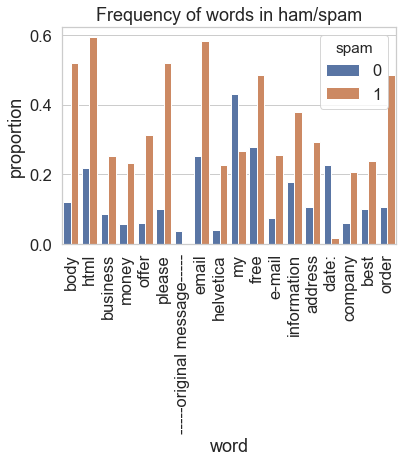

In [39]:
#make data frame with words of interest as features and rows as emails
some_words = ['body', 'html', 'business', 'money', 'offer', 'please', '-----original message-----', 'email', 'helvetica', 'my', 'free', 'e-mail', 'information', 'address', 'date:', 'company', 'best', 'order']
display(original_training_data)
data = np.array(words_in_texts(some_words, original_training_data['email']))
data_transposed = data.T
dic = {}
for x in range(len(some_words)):
    dic[some_words[x]] = data_transposed[x]
df = pd.DataFrame(dic)
df['type'] = original_training_data['spam']
display(df)
#append type to df and find amount of ham and spam to determine proportion of ham and spam with a certain word
df_ham = df[df['type'] == 0]
df_spam = df[df['type'] == 1]
display(df_ham, df_spam)
amount_ham = len(df_ham)
amount_spam = len(df_spam)

#create data frame with a row for each word and type combination 
#with features being the proportion of times the word appears in the given type of email
lst_ham = []
lst_spam = []
for x in range(18):
    lst_ham.append(df_ham.iloc[:, x].sum()/amount_ham)
    lst_spam.append(df_spam.iloc[:, x].sum()/amount_spam)
last_df = pd.DataFrame({'word':some_words+some_words, 'proportion':lst_ham+lst_spam, 'spam':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]})

#create plot
x = sns.barplot(x='word', y='proportion', hue='spam', data=last_df)
x.set_xticklabels(labels=some_words, rotation=90)
plt.title('Frequency of words in ham/spam')

Next we'll take a look to see the distribution of email length between ham and spam emails to see if there is a difference there..

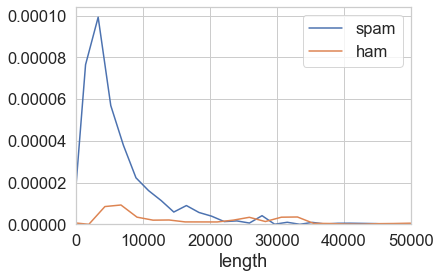

In [40]:
original_training_data['length'] = [len(x) for x in original_training_data['email']]
x = sns.distplot(original_training_data[original_training_data['spam'] == 1]['length'], hist=False, label='spam');
sns.distplot(original_training_data[original_training_data['spam'] == 0]['length'], hist=False, label='ham');
x.set(xlim=(0, 50000))
plt.legend();

Some utility functions to create new features...

In [41]:
#returns an array of number of periods, exclamation points and question marks in a given text
def punctuation(text):
    periods = text.count('.')
    exclamaition = text.count('!')
    question = text.count('?')
    total = periods + exclamaition + question
    if total == 0:
        return np.array([0, 0, 0])
    return np.array([periods, exclamaition, question])

#returns number of capital letters in a text
def capital_letters(text):
    if type(text) != str:
        return 0
    lst = [1 if text[x].isupper() else 0 for x in range(len(text))]
    if len(text) > 0:
        return sum(lst)
    return 0

#returns proportion of letters that are capitalized
def capital_letters1(text):
    if type(text) != str:
        return 0
    lst = [1 if text[x].isupper() else 0 for x in range(len(text))]
    if len(text) > 0:
        return sum(lst)/len(text)
    return 0

In [42]:
#function for processing training data before it's fed to the model
def make_pred(train):
    #create four features for the email text and subjects for the number of capital letters and proportion of capital letters
    cap_emails1 = np.array([[capital_letters1(x) for x in train['email']]])
    cap_subject1 = np.array([[capital_letters1(x) for x in train['subject']]])
    cap_emails = np.array([[capital_letters(x) for x in train['email']]])
    cap_subject = np.array([[capital_letters(x) for x in train['subject']]])
    
    #create features for length of subject and email text
    train['length_sub'] = [len(x) if type(x) == str else 0 for x in train['subject']]
    train['length_email'] = [len(x) for x in train['email']]

    some_words = ['body', 'html', 'business', 'money', 'offer', 'please', '-----original message-----', 'email', 'helvetica', 'my', 'free', 'e-mail', 'information', 'address', 'date:', 'company', 'best', 'order']
    #create features for words of interest
    X = np.array(words_in_texts(some_words, train['email']))
    L = np.array(words_in_texts(some_words, train['subject']))
    X = np.concatenate((X, L), axis=1)
                                                  
    X = np.concatenate((X, cap_emails.T), axis=1)
    X = np.concatenate((X, cap_subject.T), axis=1)
    X = np.concatenate((X, cap_emails1.T), axis=1)
    X = np.concatenate((X, cap_subject1.T), axis=1)
    
    #create features for counts of periods, exclamation points and questions marks in subject and email
    for i in range(3):
        col = np.array([[punctuation(x)[i] for x in train['email']]])
        X = np.concatenate((X, col.T), axis=1)
        col = np.array([[punctuation(x)[i] if type(x) == str else 0 for x in train['subject']]])
        X = np.concatenate((X, col.T), axis=1)
    return X


Here I'll build the model, fit it and examine its cross-validation score to get an idea of its performance.

In [43]:
import sklearn.model_selection as mod
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
#evaluating model's accuracy with cross validation
display(mod.cross_val_score(model, make_pred(original_training_data), Y_train))
model.fit(make_pred(original_training_data), Y_train)

str

C:\Users\Brandon\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Brandon\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brandon\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Brandon\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.91127874, 0.9061826 , 0.90582315])

str

C:\Users\Brandon\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)